## Make and view annual time-series data as 3-band composite

In [1]:
import os
import sys
from pathlib import Path
import datetime

import rasterio as rio
from rasterio import plot
from rasterio.plot import show
import matplotlib.pyplot as plt

from ipywidgets import Label
from ipyleaflet  import Map, GeoData, basemaps, LayersControl, ImageOverlay, Marker, Popup
from localtileserver import get_leaflet_tile_layer, TileClient

%matplotlib inline

In [2]:
sys.path.append(r"../LUCinSA_helpers")
from ts_composite import *
from plot import *
from ts_profile import *

In [3]:
'''
PARAMETERS: modify basicConfig in Notebook_settings notebook, then run that notebook and this cell to update here
DO not modify this cell
'''

%store -r basic_config
print("Basic Parameters: \n PrintDate = {} \n gridCell = {} \n index_dir = {} \n out_dir = {} \n spec_index= {}"
      .format(basic_config['today'],basic_config['grid_cell'],basic_config['index_dir'],basic_config['out_dir'],basic_config['spec_index']))
%store -r single_plot_params
print("Single Plot Parameters: \n plot_yr = {}" .format(single_plot_params['plot_yr']))
%store -r interactive_plot_params
print( "Shapefile = {} \n If point, file is {} \n If poly, file is {} \n input crs = {}"
     .format (interactive_plot_params['shpfile'], interactive_plot_params['ptfile'],interactive_plot_params['polyfile'],interactive_plot_params['inputCRS']))
#%store -r TSCompositeParams
#print("TSComposite Parameters: \n BandsOut = {}".format(TSCompositeParams['BandsOut']))
%store -r timeseries_params
print( "startYr = {} \n endYr = {}"
     .format (timeseries_params['start_yr'],timeseries_params['end_yr']))

Basic Parameters: 
 PrintDate = 2023-08-21 
 gridCell = 3807 
 index_dir = /home/downspout-cel/paraguay_lc/stac/grids/003807/brdf_ts/ms/ndmi 
 out_dir = /home/klwalker/data/tmp 
 spec_index= ndmi
Single Plot Parameters: 
 plot_yr = 2021
Shapefile = poly 
 If point, file is /home/klwalker/data/tmp/SelectedCoords.csv 
 If poly, file is /home/downspout-cel/paraguay_lc/vector/TestPolys/YerbaMatte_GEpolysEE.shp 
 input crs = epsg:8858
startYr = 2020 
 endYr = 2022


## Current options for composite bands are:
* Avg (mean)
* Max (maximum index value)
* Min (minumum index value)
* Amp (Max - Min)
* Std (standard deviation)
* CV (coefficient of variation: std/mean)
* MaxDate (day of year on which maximum occurs)
* MaxDateCos (cosine of max date, to reduce periodic effect)
* MinDate (day of year on which minimum occurs)
* MinDateCos (cosine of min date, to reduce periodic effect)
---------------------------------------------------------------
* Jan (value from Jan 10th image)
* Apr (value from Apr 10th image)
* Jun (value from Jun 10th image)
* Aug (value from Aug 10th image)
* Nov (value from Nov 10th image)

### note: if running many these, use bash script "MakeTScomposite.sh" to run on job node of cluster

## Make ['Min','Max','Amp'] composite to highlight crops vs grassland/forest

In [4]:
bands = ['Min','Max','Amp']
#bands = ['Jan','Jun','Nov']

band_name = '{}{}{}.tif'.format(bands[0],bands[1],bands[2])
comp_dir = os.path.join(basic_config['smooth_dir'],'{:06d}'.format(basic_config['grid_cell']),'comp')
comp = ('{}/{:06d}'.format(basic_config['out_dir'], basic_config['grid_cell'])+'_'+str(single_plot_params['plot_yr'])+basic_config['spec_index']+'_'+band_name+'2')
if Path(comp).exists():
    print('comp already exists')
else:
    comp = make_ts_composite(basic_config['grid_cell'],basic_config['index_dir'],basic_config['out_dir'],single_plot_params['plot_yr'],basic_config['spec_index'],bands)

00:59:12:INFO:1044:io.to_raster:  Creating the file ...

00:59:12:INFO:1051:io.to_raster:  Writing data to file ...

00:59:12:INFO:1074:io.to_raster:  Windows 1--16 of 16 ...


['Min', 'Max', 'Amp']
making max raster


100%|███████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]
00:59:19:INFO:1380:io.to_raster:
Finished writing the data.
00:59:19:INFO:1044:io.to_raster:  Creating the file ...

00:59:19:INFO:1051:io.to_raster:  Writing data to file ...

00:59:19:INFO:1074:io.to_raster:  Windows 1--16 of 16 ...


making min raster


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.36it/s]
00:59:22:INFO:1380:io.to_raster:
Finished writing the data.
00:59:22:INFO:1044:io.to_raster:  Creating the file ...

00:59:22:INFO:1051:io.to_raster:  Writing data to file ...

00:59:22:INFO:1074:io.to_raster:  Windows 1--16 of 16 ...


making amp raster


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.34it/s]
00:59:26:INFO:1380:io.to_raster:
Finished writing the data.


['/home/klwalker/data/tmp/Max.tif', '/home/klwalker/data/tmp/Min.tif', '/home/klwalker/data/tmp/Amp.tif']


## Non-interactive image with enhanced colors:

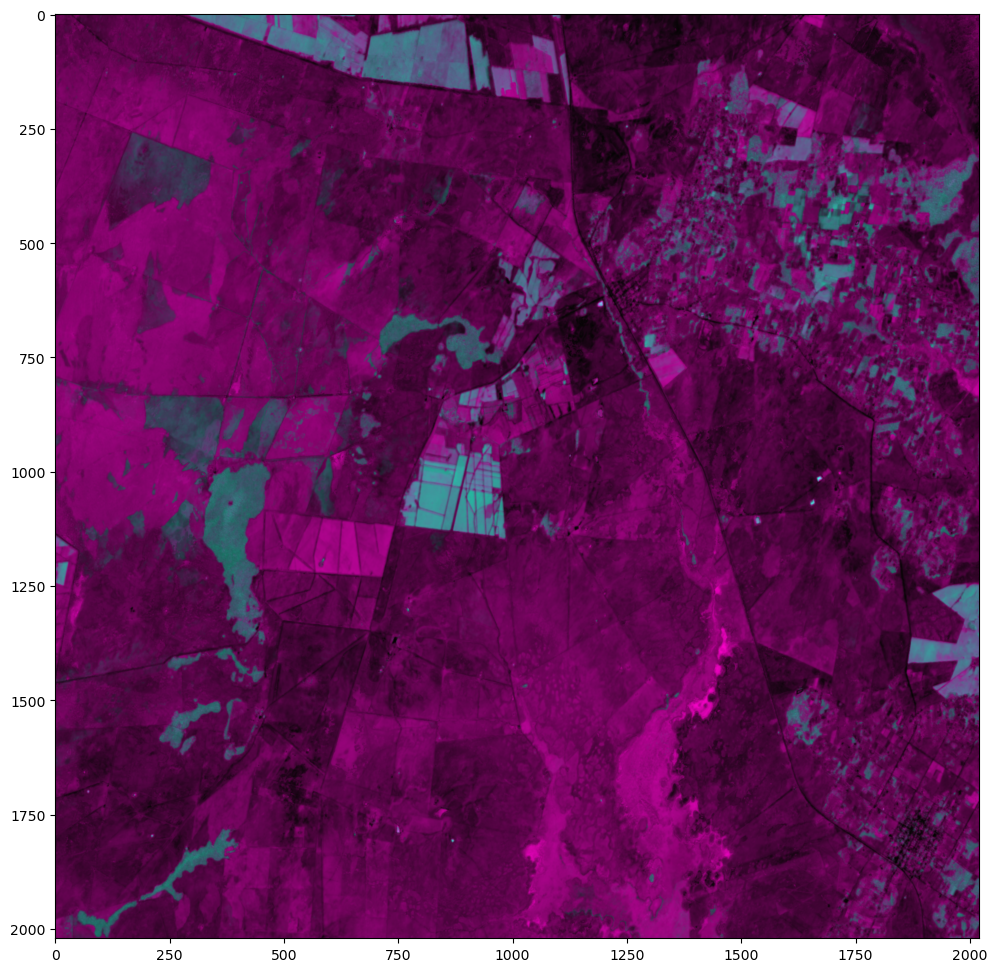

In [5]:
rgb = get_rbg_img(comp,1)
fig = plt.figure(figsize=(18,12))
plt.imshow(rgb);

## Interactive image (to query points for timeseries profile)

In [6]:
tile_client = TileClient(comp,port=5554)
m = Map(center=tile_client.center(), zoom=12, basemap=basemaps.Esri.WorldImagery)
t = get_leaflet_tile_layer(tile_client, band=[3,2,1])
m.add_layer(t)

def get_coords(**kwargs):
    if kwargs.get('type') == 'click':
        label = Label()
        label.value = str(kwargs.get('coordinates'))
        #m.add_layer(Marker(location=kwargs.get('coordinates')))
        coords =eval(label.value) 
        selected_coords.append(coords)
        print(selected_coords)
        return selected_coords
selected_coords = []
m.on_interaction(get_coords)

print('click on map to get coordinates to query (can zoom in first)')
m

click on map to get coordinates to query (can zoom in first)


Map(center=[-26.389379121140127, -56.50777064878126], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [7]:
#coords = convert_and_print_coord_list(selected_coords, img_crs=interactive_plot_params['inputCRS'], out_dir=basic_config['out_dir'])
coords = pd.read_csv(os.path.join(basic_config['out_dir'],'SelectedCoords.csv'))
vals = get_values_at_coords(coords, interactive_plot_params['inputCRS'], comp, [1,2,3])

print(coords)

for index, pt in coords.iterrows():
    marker = Marker(location = [pt.lon,pt.lat])
    popup = Popup(
        location=[pt.lon,pt.lat],
        close_button=False,
        auto_close=False,
        close_on_click=False,
        close_on_escape_key=False
    )
    popup.children = "{}: {}/{}/{}".format(index+1,vals[1][index],vals[2][index],vals[3][index])
    print(popup.children)
    message=Label()
    message.value = popup.children
    marker.popup = message
    m.add_layer(marker)

display(m)

   Unnamed: 0        XCoord        YCoord        lat        lon
0           0  3.041069e+06 -3.329755e+06 -56.592916 -26.390640
1           1  3.042275e+06 -3.328298e+06 -56.581244 -26.378645
2           2  3.048250e+06 -3.329195e+06 -56.514639 -26.386026
3           3  3.048678e+06 -3.330875e+06 -56.508116 -26.399865
1: 4412/291/4121
2: 3047/1362/1685
3: 4635/1482/3153
4: 2168/293/1875


Map(bottom=604224.0, center=[-26.389379121140127, -56.50777064878126], controls=(ZoomControl(options=['positio…

## Get time series for pts

In [8]:
coords = os.path.join(basic_config['out_dir'],'SelectedCoords.csv')

ts_smooth = get_timeseries_for_pts_multicell(basic_config['out_dir'], basic_config['spec_index'], timeseries_params['start_yr'], timeseries_params['end_yr'],
            basic_config['smooth_dir'], 'Smooth', basic_config['grid_file'], timeseries_params['grid_cells'], 
            ground_polys=timeseries_params['ground_polys'], oldest=timeseries_params['oldest_samp'], newest=timeseries_params['newest_samp'],
            npts=timeseries_params['npts'], seed=timeseries_params['seed1'], load_samp=True, ptfile=coords)

ts_raw =   get_timeseries_for_pts_multicell(basic_config['out_dir'], basic_config['spec_index'], timeseries_params['start_yr'], timeseries_params['end_yr'],
            basic_config['raw_dir'], 'AllRaw', basic_config['grid_file'], timeseries_params['grid_cells'], 
            ground_polys=timeseries_params['ground_polys'], oldest=timeseries_params['oldest_samp'], newest=timeseries_params['newest_samp'],
            npts=timeseries_params['npts'], seed=timeseries_params['seed1'], load_samp=True, ptfile=coords)

working on cell 3807
grid is in:  epsg:8858
                                            geometry
0  POLYGON ((3058830.886 -3339608.696, 3058830.88...
Of the 4 ppts, 4 are in gridCell 3807
getting index values...
                           geometry  2020153  2020162  2020172  2020183  \
0  POINT (3041069.149 -3329754.978)      292      381      571     1177   
1  POINT (3042275.277 -3328298.193)     1920     1672     1073      361   
2  POINT (3048250.129 -3329194.703)      871      825      840     1045   
3  POINT (3048677.934 -3330875.426)      295      306      362      471   

   2020192  2020202  2020214  2020223  2020233  ...  2022051  2022060  \
0     1382     1356     1278     1214     1119  ...     3372     3405   
1      273      286      298      300      300  ...     2502     2630   
2     1038     1003      941      769      639  ...     2618     2817   
3      439      403      414      433      404  ...      312      293   

   2022069  2022079  2022091  2022100  2022110

## show output

Map(bottom=604224.0, center=[-26.389379121140127, -56.50777064878126], controls=(ZoomControl(options=['positio…

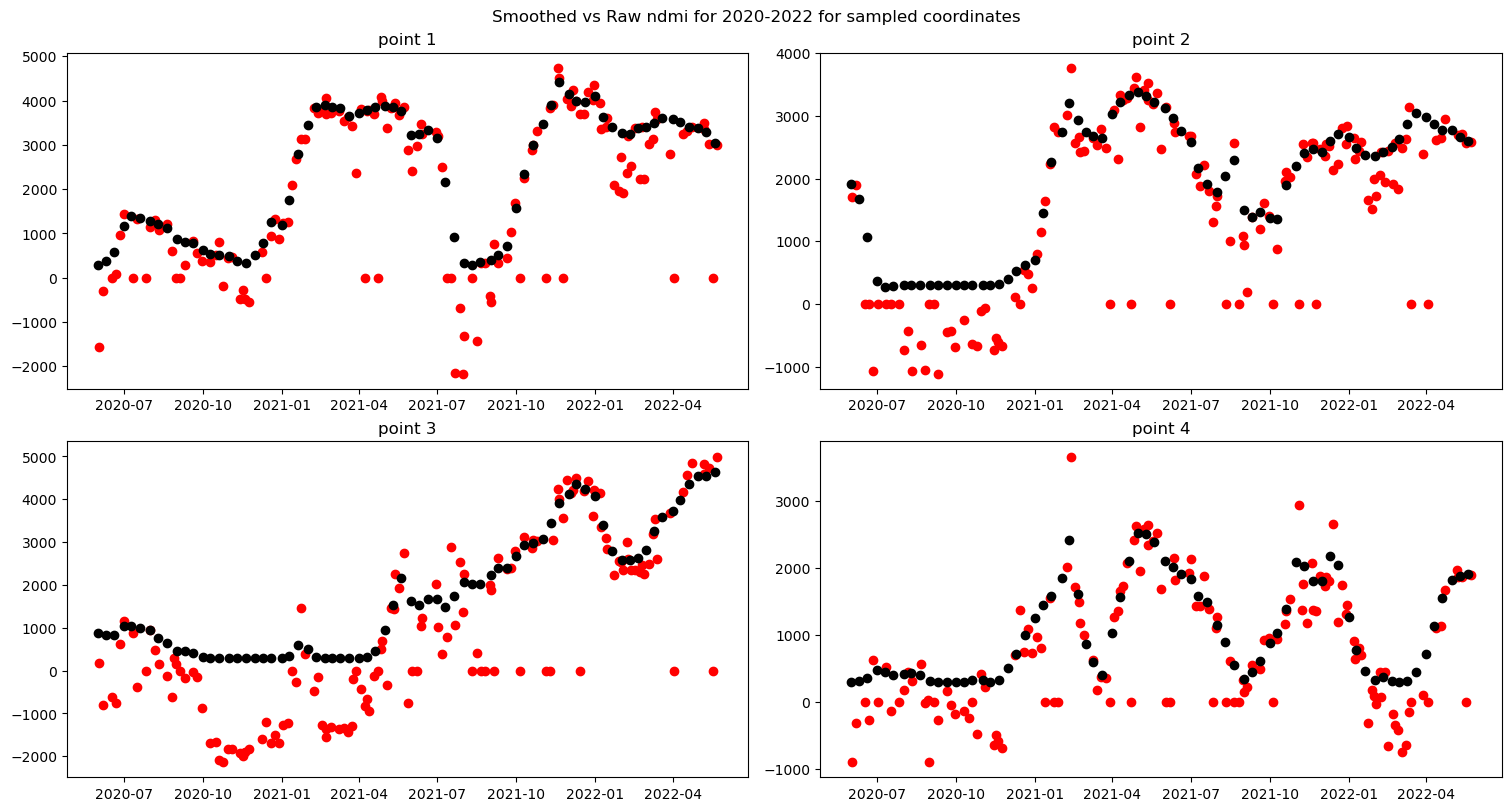

In [9]:
display(m)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 8), layout="constrained")
axs[0,0].errorbar(ts_raw.index, ts_raw[0], fmt='o', color='r')                
axs[0,0].errorbar(ts_smooth.index, ts_smooth[0], fmt='o', color='k')
axs[0,0].set_title('point 1')
axs[0,1].errorbar(ts_raw.index, ts_raw[1], fmt='o', color='r')                      
axs[0,1].errorbar(ts_smooth.index, ts_smooth[1], fmt='o', color='k')
axs[0,1].set_title('point 2')
axs[1,0].errorbar(ts_raw.index, ts_raw[2], fmt='o', color='r')                        
axs[1,0].errorbar(ts_smooth.index, ts_smooth[2], fmt='o', color='k')
axs[1,0].set_title('point 3')
axs[1,1].errorbar(ts_raw.index, ts_raw[3], fmt='o', color='r')                        
axs[1,1].errorbar(ts_smooth.index, ts_smooth[3], fmt='o', color='k')
axs[1,1].set_title('point 4')
fig.suptitle('Smoothed vs Raw {} for {}-{} for sampled coordinates'.format(basic_config['spec_index'],timeseries_params['start_yr'],timeseries_params['end_yr']));

if saving this notebook as static HTML, 
need to make an JPEG of the interactive composite with point markers above and post it here 
(interactive maps from localtileserver will not render with nbconvert currently)
delete the image after rendering and reinsert this text

## to show one point in more detiail:

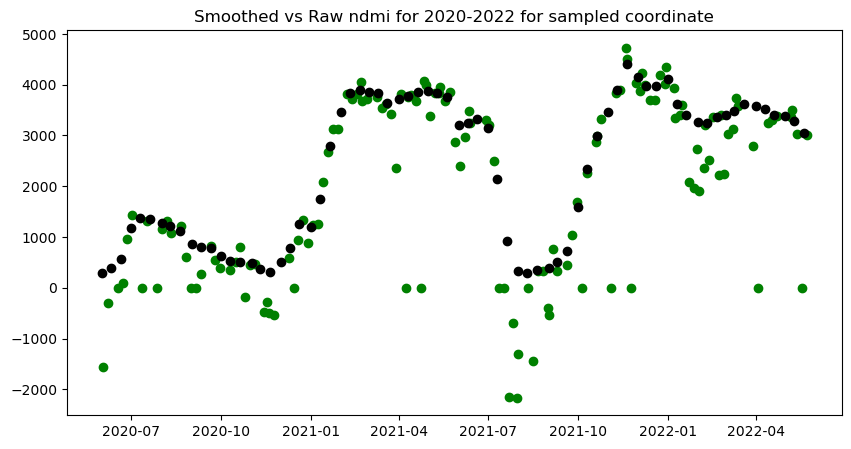

In [10]:
fig = plt.figure(figsize=(10, 5))
plt.errorbar(ts_raw.index, ts_raw[0], fmt='o', color='g')
plt.errorbar(ts_smooth.index, ts_smooth[0], fmt='o', color='k')
plt.title('Smoothed vs Raw {} for {}-{} for sampled coordinate'.format(basic_config['spec_index'],timeseries_params['start_yr'],timeseries_params['end_yr']))
#plt.ylim(0,7000)
plt.show();

## Make ['Jan','Jun','Nov'] composite to see different crops

In [ ]:
bands = ['Jan','Jun','Nov']
band_name = '{}{}{}.tif'.format(bands[0],bands[1],bands[2])
comp_dir = os.path.join(basic_config['smooth_dir'],'{:06d}'.format(basic_config['grid_cell']),'comp')
comp2 = ('{}/{:06d}'.format(comp_dir, basic_config['grid_cell'])+'_'+str(single_plot_params['plot_yr'])+basic_config['spec_index']+'_'+band_name+'2')
if Path(comp2).exists():
    print('comp already exists')
else:
    comp2 = make_ts_composite(basic_config['grid_cell'],basic_config['index_dir'],basic_config['out_dir'],single_plot_params['plot_yr'],basic_config['spec_index'],bands)

In [ ]:
rgb = get_rbg_img(comp2,1)
fig = plt.figure(figsize=(18,12))
plt.imshow(rgb);

# To save an html copy of this notebook with all outputs:

In [11]:
### Run to print output as html

out_name = str(basic_config['country']+'2b_ViewTimeSeriesComposite'+'_cell'+str(basic_config['grid_cell'])+'_'+str(single_plot_params['plot_yr'])+'NDMI_wh_oldNorm')
!jupyter nbconvert --output-dir='./Outputs' --to html --no-input --ExecutePreprocessor.store_widget_state=True --output=$out_name 2b_ViewTimeSeriesComposite.ipynb

[NbConvertApp] Converting notebook 2b_ViewTimeSeriesComposite.ipynb to html
[NbConvertApp] Writing 2797147 bytes to Outputs/Paraguay2b_ViewTimeSeriesComposite_cell3807_2021NDMI_wh_oldNorm.html
